# Introduction

The National Agriculture Imagery Program (NAIP) provides high-resolution satellite imagery of the United States to the public via an [Amazon Web Services (AWS) S3 bucket](https://aws.amazon.com/public-datasets/naip/).

Essentially, the US is broken into a grid of cells called quadrangles, and images NAIP provides correspond to cells in this grid. This function converts a (latitude, longitude) coordinate pair into the grid cell name/identifier that contains the coordinate pair as it appears in the NAIP AWS bucket. With a little bit more work, we use this function to automate the process of downloading NAIP images based on simple names like "Golden Gate Bridge, NY".

```python
import numpy as np
def get_doqq_id(lat, lon):
    
    ## Assume 8x8 grid
    grid_size = 8
    grid_step = 1 / grid_size 
    
    ## Find index in 1-degree block (8x8 grid)
    ## NOTE: Quadrangles are 1-indexed
    lat_decimals = lat - int(lat)
    lon_decimals = lon - int(lon)
    row_ndx = (grid_size - 1) - int(lat_decimals / grid_step)
    col_ndx = (grid_size - 1) + int(lon_decimals / grid_step)
    ndx = 1 + np.ravel_multi_index((row_ndx , col_ndx), (grid_size, grid_size))
    
    ## Find quadrant (nw, ne, sw, se)
    lon_upper = int(lon) - grid_step * (grid_size - col_ndx - 1)
    lon_lower = int(lon) - grid_step * (grid_size - col_ndx)
    lat_upper = int(lat) + grid_step * (grid_size - row_ndx)
    lat_lower = int(lat) + grid_step * (grid_size - row_ndx - 1)
    lon_mid = (lon_upper + lon_lower) / 2
    lat_mid = (lat_upper + lat_lower) / 2
    if lat > lat_mid:
        quadrant = 'n'
    else:
        quadrant = 's'
        
    if lon > lon_mid:
        quadrant = quadrant + 'e'
    else:
        quadrant = quadrant + 'w'
    
    ## Format output string
    lat_str = str(int(lat))
    if abs(lon) < 100:
        lon_str = '0' + str(abs(int(lon)))
    else:
        lon_str = str(abs(int(lon)))
    
    if ndx < 10:
        ndx_str = '0' + str(ndx)
    else:
        ndx_str = str(ndx)
    
    return lat_str + lon_str + ndx_str + '_' + quadrant
```


Inputs are in decimal degrees such as

```python
get_doqq_id(37.8199286, -122.4782551)
```
which returns 

`3712213_nw`

As we'll see below, this cell identifier indeed corresponds to an NAIP image that contains those coordinates which in fact point to the Golden Gate Bridge.

# Prerequisites

## AWS CLI
In addition to the Python libraries imported below, you should have the AWS command-line interface installed and configured if you want to use the NAIP bucket. (Because of a [permission issue](https://github.com/mapbox/s3pay/issues/1), the AWS library `boto3` won't work with the NAIP bucket.) Then, download the entire NAIP manifest with a shell command like

```shell
aws s3api get-object --bucket aws-naip --key manifest.txt --request-payer requester naip/manifest.txt
```

## Quadrangle Primer

The manifest lists all the files hosted on the NAIP bucket. The [naming convetion](https://lta.cr.usgs.gov/naip_full_res.html#naip_entity_id) of each file is based on the [USGS quadrangle standards](https://topomaps.usgs.gov/drg/drg_name.html#hdr%209). As an example, the quadrangle called `3712213` is located in a swath of the earth encompassing latitude degrees `37` (the first two digits of the quadrangle identifier) to `38` and longitude degrees `-122` (the next three digits) to `-123`. Then, This `1x1` degree block is then broken down further into an `8x8` grid with the southeast corner of the grid corresponding to `(37, -122)` and the northwest corner to `(38, -123)`. Thus, each grid cell covers `0.125` degrees of longitude and latitude. By NAIP conventions, the indexing of cells within the `1x1` degree block starts in the northwest corner with index `1`, and the index corresponds to the last two digits of the identifier. In our example, the index `13` corresponds to the cell in the second row and fifth column of the `1x1` degree block.

`grep` through the manifest to find all files corresponding to the example quadrangle `3712213`.

```shell
grep "3712213" naip/manifest.txt
```

returns a list of files like

```shell
ca/2012/1m/fgdc/37122/m_3712213_ne_10_1_20120520.txt
ca/2012/1m/fgdc/37122/m_3712213_nw_10_1_20120520.txt
ca/2012/1m/fgdc/37122/m_3712213_se_10_1_20120520.txt
ca/2012/1m/fgdc/37122/m_3712213_sw_10_1_20120520.txt
ca/2012/1m/rgb/37122/m_3712213_ne_10_1_20120520.tif
ca/2012/1m/rgb/37122/m_3712213_nw_10_1_20120520.tif
ca/2012/1m/rgb/37122/m_3712213_se_10_1_20120520.tif
ca/2012/1m/rgb/37122/m_3712213_sw_10_1_20120520.tif
ca/2012/1m/rgbir/37122/m_3712213_ne_10_1_20120520.tif
ca/2012/1m/rgbir/37122/m_3712213_nw_10_1_20120520.tif
ca/2012/1m/rgbir/37122/m_3712213_se_10_1_20120520.tif
ca/2012/1m/rgbir/37122/m_3712213_sw_10_1_20120520.tif
ca/2014/1m/fgdc/37122/m_3712213_ne_10_1_20140608.txt
ca/2014/1m/fgdc/37122/m_3712213_nw_10_1_20140608.txt
ca/2014/1m/fgdc/37122/m_3712213_se_10_1_20140613.txt
ca/2014/1m/fgdc/37122/m_3712213_sw_10_1_20140613.txt
ca/2014/1m/rgb/37122/m_3712213_ne_10_1_20140608.tif
ca/2014/1m/rgb/37122/m_3712213_nw_10_1_20140608.tif
ca/2014/1m/rgb/37122/m_3712213_se_10_1_20140613.tif
ca/2014/1m/rgb/37122/m_3712213_sw_10_1_20140613.tif
ca/2014/1m/rgbir/37122/m_3712213_ne_10_1_20140608.tif
ca/2014/1m/rgbir/37122/m_3712213_nw_10_1_20140608.tif
ca/2014/1m/rgbir/37122/m_3712213_se_10_1_20140613.tif
ca/2014/1m/rgbir/37122/m_3712213_sw_10_1_20140613.tif
ca/2016/.6m/fgdc/37122/m_3712213_ne_10_h_20160625.txt
ca/2016/.6m/fgdc/37122/m_3712213_nw_10_h_20160625.txt
ca/2016/.6m/fgdc/37122/m_3712213_se_10_h_20160625.txt
ca/2016/.6m/fgdc/37122/m_3712213_sw_10_h_20160625.txt
ca/2016/.6m/rgb/37122/m_3712213_ne_10_h_20160625.tif
ca/2016/.6m/rgb/37122/m_3712213_nw_10_h_20160625.tif
ca/2016/.6m/rgb/37122/m_3712213_se_10_h_20160625.tif
ca/2016/.6m/rgb/37122/m_3712213_sw_10_h_20160625.tif
ca/2016/.6m/rgbir/37122/m_3712213_ne_10_h_20160625.tif
ca/2016/.6m/rgbir/37122/m_3712213_nw_10_h_20160625.tif
ca/2016/.6m/rgbir/37122/m_3712213_se_10_h_20160625.tif
ca/2016/.6m/rgbir/37122/m_3712213_sw_10_h_20160625.tif
```

Notice a few things about the files in the manifest. First, files are grouped by state. It happens that the quadrangle picked corresponds exclusively to California, but some quadrangles might encompass multiple states. Second, there are multiple years of data (`2012`, `2014`, and `2016` in this case). Then, the `1m` or `.6m` directiories correspond to the resolution of the images (e.g. `1` meter per pixel). The next directory tells what type of data is stored there such as `rgb` for RGB images or `fgdc` for metadata text files. The rest of the path is based on the quadrangle and other properties of the image data. 

Also note the intercardinal directions in the filenames such as `nw` (northwest). With NAIP data, each quadrangle tile is broken up into four chunks or quadrants. Each chunk is called a digital ortho quarter quad (DOQQ) tile since it covers a fourth of specified the quadrangle. If you want data for an entire city, you'll probably want to download all chunks of a quadrangle, but if you're interested in a specific landmark like a building, then you'll need to figure out which chunk contains the landmark as done below.

The rest of this notebook shows how to convert a (latitude, longitude) pair into the specific DOQQ that contains the pair. Further, we automate the process of inputting simple landmark names like "Golden Gate Bridge, CA" and outputting a subset of the NAIP image that contains the landmark

# Code

## Dependencies

In [19]:
import rasterio
from rasterio.mask import mask as rio_mask
from rasterio.features import rasterize
from geopy.geocoders import GoogleV3
from shapely.geometry import box
from pyproj import Proj

import pprint
import os
import subprocess

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

The main function `get_doqq_id` converts an input (latitude, longitude) pair into the corresponding DOQQ identifier. We assume that were are working with US data as provided by NAIP on AWS, so a key assumption is that latitude is positive and longitude is negative. This makes it easier to find the correct row and column indicies within the `1`-degree `8x8` grid. Adapting this function for other parts of the globe is left as an exercise for the reader.

In [20]:
def get_doqq_id(lat, lon):
    
    ## Assume 8x8 grid
    grid_size = 8
    grid_step = 1 / grid_size 
    
    ## Find index in 1-degree block (8x8 grid)
    ## NOTE: Quadrangles are 1-indexed
    lat_decimals = lat - int(lat)
    lon_decimals = lon - int(lon)
    row_ndx = (grid_size - 1) - int(lat_decimals / grid_step)
    col_ndx = (grid_size - 1) + int(lon_decimals / grid_step)
    ndx = 1 + np.ravel_multi_index((row_ndx , col_ndx), (grid_size, grid_size))
    
    ## Find quadrant (nw, ne, sw, se)
    lon_upper = int(lon) - grid_step * (grid_size - col_ndx - 1)
    lon_lower = int(lon) - grid_step * (grid_size - col_ndx)
    lat_upper = int(lat) + grid_step * (grid_size - row_ndx)
    lat_lower = int(lat) + grid_step * (grid_size - row_ndx - 1)
    lon_mid = (lon_upper + lon_lower) / 2
    lat_mid = (lat_upper + lat_lower) / 2
    if lat > lat_mid:
        quadrant = 'n'
    else:
        quadrant = 's'
        
    if lon > lon_mid:
        quadrant = quadrant + 'e'
    else:
        quadrant = quadrant + 'w'
    
    ## Format output string
    lat_str = str(int(lat))
    if abs(lon) < 100:
        lon_str = '0' + str(abs(int(lon)))
    else:
        lon_str = str(abs(int(lon)))
    
    if ndx < 10:
        ndx_str = '0' + str(ndx)
    else:
        ndx_str = str(ndx)
    
    return lat_str + lon_str + ndx_str + '_' + quadrant

## Landmarks to DOQQ

Let's use this function to find the DOQQ tiles for some different landmarks. We start by definding the `places` container to be a dictionary of dictionaries. The key is the name of the landmark, and the value is another dictionary that will hold some useful info such as the state the landmark is located in and its (latitude, longitude) coordinates. 

To get the coordinates, I prefer using Google's geolocator (part of the `geopy` library) with an API key (mine is stored in an environment variable), but substituting in the Open Street Map geolocator is easy enough:

```python
from geopy.geocoders import Nominatim
geolocator = Nominatim()
```

Besides that, the rest of the code is identical.

In [21]:
places = {
    'Statue of Liberty' : {'state': 'ny'},
    'Walt Disney World Resort': {'state': 'fl'},
    'Hoover Dam': {'state': 'az'},
    'Golden Gate Bridge': {'state': 'ca'}
}

api_key = os.environ.get('GOOG_GEOLOCATOR_API_KEY')
geolocator = GoogleV3(api_key)

for place, place_info in places.items():
    state = place_info['state']
    loc = geolocator.geocode(place + ' ' + state)
    lat, lon = loc.latitude, loc.longitude
    doqq_id = get_doqq_id(lat, lon)
    
    place_info['doqq_id'] = doqq_id
    place_info['coords'] = (lat, lon)

    
pprint.pprint(places)

{'Golden Gate Bridge': {'coords': (37.8199286, -122.4782551),
                        'doqq_id': '3712213_nw',
                        'state': 'ca'},
 'Hoover Dam': {'coords': (36.0157617, -114.7376675),
                'doqq_id': '3611459_sw',
                'state': 'az'},
 'Statue of Liberty': {'coords': (40.6892494, -74.04450039999999),
                       'doqq_id': '4007424_ne',
                       'state': 'ny'},
 'Walt Disney World Resort': {'coords': (28.3679302, -81.56034849999999),
                              'doqq_id': '2808144_ne',
                              'state': 'fl'}}


## Find image files

With the DOQQ identifiers in place, we then search the manifest for the RGB image files that contain each landmark. Once a corresponding image file is found is found, we add its NAIP key to the info dictionary so we can download it later. Note that we'll likely find multiple files for each landmark corresponding to different collection years and states, but for this excersize that's okay since we just want some image that contains the landmark. So, we let new file keys overwrite old ones. Readers who need data from specific states or collection years would have to refine this search. 



In [7]:
manifest_path = 'naip/manifest.txt'
doqq_ids = [place_info['doqq_id'] for place_info in places.values()]

with open(manifest_path, 'r') as manifest:
    for line in manifest:
        if '/rgb/' in line:
            for place, place_info in places.items():
                if place_info['doqq_id'] in line:
                    place_info['naip_key'] = line.strip()
            
print()
pprint.pprint(places)


{'Golden Gate Bridge': {'coords': (37.8199286, -122.4782551),
                        'doqq_id': '3712213_nw',
                        'naip_key': 'ca/2016/.6m/rgb/37122/m_3712213_nw_10_h_20160625.tif',
                        'state': 'ca'},
 'Hoover Dam': {'coords': (36.0157617, -114.7376675),
                'doqq_id': '3611459_sw',
                'naip_key': 'nv/2015/1m/rgb/36114/m_3611459_sw_11_1_20150529.tif',
                'state': 'az'},
 'Statue of Liberty': {'coords': (40.6892494, -74.04450039999999),
                       'doqq_id': '4007424_ne',
                       'naip_key': 'ny/2015/.5m/rgb/40074/m_4007424_ne_18_h_20150522.tif',
                       'state': 'ny'},
 'Walt Disney World Resort': {'coords': (28.3679302, -81.56034849999999),
                              'doqq_id': '2808144_ne',
                              'naip_key': 'fl/2015/1m/rgb/28081/m_2808144_ne_17_1_20151123.tif',
                              'state': 'fl'}}


## Download image files

Now, loop through the landmarks and download the NAIP file that was found to contain the landmark. A check is added to ensure we don't download files that have already been downloaded.


In [9]:
aws_cmd_base = 'aws s3api get-object --bucket aws-naip --key {} --request-payer requester {}'
img_dir = 'naip/img/'

for place, place_info in places.items():
    
    ## Create local image path
    key = place_info['naip_key']
    img_path = img_dir + key.split('/')[-1]
    place_info['img_path'] = img_path
    
    ## Download from NAIP if not already downloaded
    aws_cmd = aws_cmd_base.format(key, img_path)
    if os.path.isfile(img_path):
        print('Skipping {}\n'.format(key))
    else:
        print('Downloading {} with the following command:\n{}\n'.format(key, aws_cmd))
        subprocess.run(aws_cmd, shell = True)

print()
pprint.pprint(places)

Skipping ny/2015/.5m/rgb/40074/m_4007424_ne_18_h_20150522.tif

Skipping fl/2015/1m/rgb/28081/m_2808144_ne_17_1_20151123.tif

aws s3api get-object --bucket aws-naip --key nv/2015/1m/rgb/36114/m_3611459_sw_11_1_20150529.tif --request-payer requester naip/img/m_3611459_sw_11_1_20150529.tif

aws s3api get-object --bucket aws-naip --key ca/2016/.6m/rgb/37122/m_3712213_nw_10_h_20160625.tif --request-payer requester naip/img/m_3712213_nw_10_h_20160625.tif


{'Golden Gate Bridge': {'coords': (37.8199286, -122.4782551),
                        'doqq_id': '3712213_nw',
                        'img_path': 'naip/img/m_3712213_nw_10_h_20160625.tif',
                        'naip_key': 'ca/2016/.6m/rgb/37122/m_3712213_nw_10_h_20160625.tif',
                        'state': 'ca'},
 'Hoover Dam': {'coords': (36.0157617, -114.7376675),
                'doqq_id': '3611459_sw',
                'img_path': 'naip/img/m_3611459_sw_11_1_20150529.tif',
                'naip_key': 'nv/2015/1m/rgb/36114/m_36114

## Extract and plot landmarks

To verify the function works, for each landmark we

1. Open the corresponding downloaded image file
2. Extract a subset of the image file centered on the landmark
3. Draw a small box around the landmark

These steps are wrapped up into the function `create_subset` defined below. 

In [16]:
def create_subset(img_path, lat, lon, mask_len = 1500, box_len = 500, box_pad = 10):
    '''
    img_path: Path to a GeoTiff containing (lat, lon).
    lat, lon: Coordinates that the output will be centered on.
    mask_len: Side length in meters of the cropped output image.
    box_len: Side length in meters of a box drawn around (lat, lon)
    box_pad: Line width in pixels of the box
    '''
    
    with rasterio.open(img_path) as src:
    
        ## Project feature lat,lon onto image
        proj = Proj(src.crs)
        x,y = proj(lon, lat)

        ## Make mask centered at the feature
        mask_shape = box(x-mask_len/2, y-mask_len/2, x+mask_len/2, y+mask_len/2)
        mask = {'type': 'Polygon', 'coordinates': [list(mask_shape.exterior.coords)]}

        ## Extract only the data within the mask, put color channels last
        img_out, trans_out = rio_mask(src, [mask], crop = True)
        img_out = np.swapaxes(img_out, 0, 2)
        img_out = np.swapaxes(img_out, 0, 1)

        ## Create a feature box centered at the feature
        pix_per_meter = src.res[0]
        box_len_pix = int(box_len / pix_per_meter)
        box_feat = np.zeros(img_out.shape[0:2])
        top = int(box_feat.shape[0] / 2 - box_len_pix / 2)
        left = int(box_feat.shape[1] / 2 - box_len_pix / 2)
        bottom = top + box_len_pix
        right = left + box_len_pix
        box_feat[top:top+box_pad, left:right] = 1
        box_feat[bottom:bottom+box_pad, left:right] = 1
        box_feat[top:bottom, left:left+box_pad] = 1
        box_feat[top:bottom, right:right+box_pad] = 1

        ## Overlay feature box on image
        img_out[box_feat == 1] = [255, 0 ,0]
        return img_out

Finally, we loop through each landmark and plot the corresponding subset that contains it.

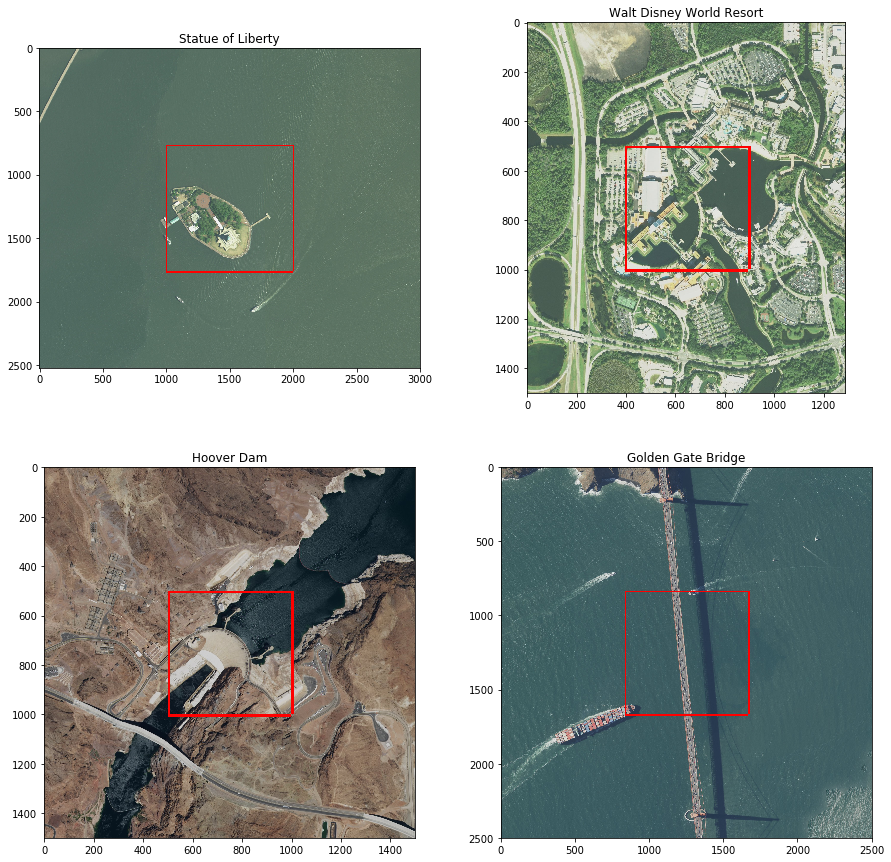

In [17]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
axes = axes.flatten()

for i, (place, place_info) in enumerate(places.items()):

    img_path = place_info['img_path']
    lat, lon = place_info['coords']
    img_arr = create_subset(img_path, lat, lon)
    
    ax = axes[i]
    ax.set_title(place)
    ax.imshow(img_arr)
    
fig.savefig('example_images.png')

If you don't recognize the landmarks from the NAIP images above, check it out on Google Maps satellite view and verify we are looking at the correct locations. 

If you're working with NAIP data yourself, you'll likely want to modify the given code to download the metadata and RGB+IR (infrared) images. I hope this has post has given you a solid base to start your project!